# Model Testing

The goal of this notebook is to estimate the reliability of our model with respect to the real data.

In order to make it, we use November 2023 data, which had not previously been used as not available, during the model creation phase.

First of all, we download all November 2023 data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sys

local_path = os.getcwd()
src_path = os.sep.join(local_path.split(os.sep)[:-1])

sys.path.append(src_path)

from google.cloud import bigquery
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from demo_lib import *

# Create a "Client" object
client = bigquery.Client()

# Write the query to get November 2023 data
query_ride_counts = """
SELECT
  EXTRACT(DAY FROM trip_start_timestamp) AS Day,
  COUNT(1) AS num_trips,
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  trip_start_timestamp BETWEEN TIMESTAMP("2023-11-01") AND TIMESTAMP("2023-11-30")
GROUP BY
  Day
ORDER BY
  Day;
"""

# Create the temporary dataframe
df = client.query(query_ride_counts).to_dataframe()

y_test = df.set_index('Day')['num_trips'].values
y_test

2023-12-12 17:02:54.508302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 17:02:55.533000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-12-12 17:02:55.533117: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

<IntegerArray>
[20098, 20272, 19673, 14510, 14949, 19780, 20605, 22388, 22342, 18936, 13492,
 14581, 20008, 20200, 20959, 21578, 19578, 12556, 10674, 14482, 15053, 13248,
  7163, 12373, 15412, 16020, 21823, 23014, 21496,    78]
Length: 30, dtype: Int64

Clearly, the last data point is incomplete, so we discard it.

In [2]:
y_test = y_test[:-1]
y_test

<IntegerArray>
[20098, 20272, 19673, 14510, 14949, 19780, 20605, 22388, 22342, 18936, 13492,
 14581, 20008, 20200, 20959, 21578, 19578, 12556, 10674, 14482, 15053, 13248,
  7163, 12373, 15412, 16020, 21823, 23014, 21496]
Length: 29, dtype: Int64

Now we perform the predictions.

In [3]:
def get_forecast(day, n_forecasts=10):
    if len(str(day)) == 1:
        day = f'0{day}'
    else:
        day = str(day)

    # Return the mean value of 10 different forecasts to limit the impact of random fluctuations
    return round(np.mean([forecast(*load_model(), f"2023-11-{day}") for _ in range(n_forecasts)]))
y_pred = Parallel(n_jobs=-1)(delayed(get_forecast)(day) for day in tqdm(range(1, 30)))

100%|██████████| 29/29 [00:00<00:00, 82.05it/s]
2023-12-12 17:03:00.234558: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 17:03:00.241415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 17:03:00.258998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

In [4]:
y_pred = np.array(y_pred)
y_pred

array([20486, 20749, 19390, 13892, 13848, 17426, 17793, 20189, 20825,
       19578, 14009, 13840, 17418, 18262, 20417, 20848, 19252, 13894,
       13939, 17243, 18423, 20320, 20583, 19535, 13809, 13836, 17451,
       17356, 20286])

Now we compute the RMSE.

In [5]:
mean_squared_error(y_test, y_pred, squared=False)

3750.992907631718

Finally, we plot the two curves in order to have a visual confirmation of the goodness of fit.

<Axes: >

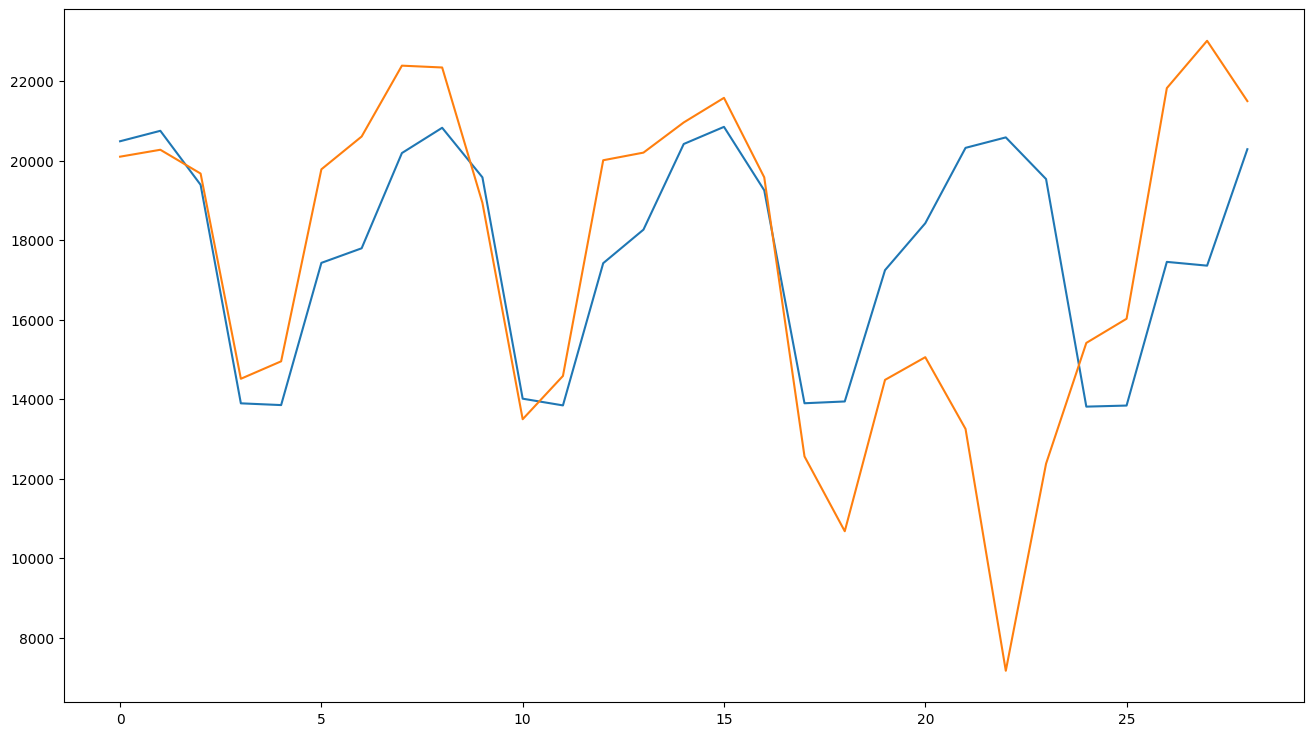

In [6]:
fig, ax = plt.subplots(1, figsize=(16, 9))
sns.lineplot(y_pred, ax=ax)
sns.lineplot(y_test, ax=ax)

In conclusion, it appears that our model is capable of successfully forecasting the future values of the daily taxi rides.